In [19]:
# This section initializes imports, warning suppression, global variables, and working dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import researchpy as rp
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.descriptivestats as ds
import statsmodels.stats.multicomp as mc
import warnings
from statsmodels.formula.api import ols
from statsmodels.compat import lzip

# Supress unwanted errors from script output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Manually define a tab variable because \t isn't working right
# And I don't want to take the time to figure out why, when I can brute force it :)
tab = "        "

# Import data after exclusion from csv
df = pd.read_csv("/workspaces/codespaces-blank/data/final-dataset-aaa26.csv")

df_min = df[['ID', 'Gender', 'Birthdate', 'Evaluation_Date', 'Age_Day',
             'Age_Month_Round', 'Age_Year_Round', 'Home_Language_Simple', 
             'Household_Status', 'Marital_Status', 'Maternal_Education', 
             'Indicator_SLD_Or_ADHD', 'Aided_Side', 'Aided_Type', 
             'Device_Usage', 'Testing_Language', 'SLP', 'WPS_Category', 
             'WPS_Score', 'Instrument', 'Language_Score']]
df_min.rename(columns={'Age_Day': 'Age_Days', 'Age_Month_Round': 'Age_Months',
                      'Age_Year_Round': 'Age_Years','Home_Language_Simple': 'Language',
                      'Household_Status': 'Household', 'Marital_Status': 'Marriage',
                      'Maternal_Education': 'Education', 'Indicator_SLD_Or_ADHD': 'SLD', 
                      'Aided_Side': 'Side', 'Aided_Type': 'Type', 'Device_Usage': 'Usage', 
                      'Testing_Language': 'Test_Language', 'WPS_Score': 'WPS'},
                      inplace=True)

df_ess = df[['ID', 'Age_Month_Round', 'Home_Language_Simple', 'Household_Status', 
             'Marital_Status', 'Maternal_Education', 'Indicator_SLD_Or_ADHD', 'WPS_Score']]
df_ess.rename(columns={'Age_Month_Round': 'Age', 'Home_Language_Simple': 'Language',
                       'Household_Status': 'Household', 'Marital_Status': 'Marriage', 
                       'Maternal_Education': 'Education', 'Indicator_SLD_Or_ADHD': 
                       'Indicator', 'WPS_Score': 'WPS'}, inplace=True)

filter = ['ASL', 'Spanish', 'Other', 'Unknown']
df_ess = df_ess[~df_ess['Language'].isin(filter)]

/tmp/ipykernel_2038/4085072867.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min.rename(columns={'Age_Day': 'Age_Days', 'Age_Month_Round': 'Age_Months',
/tmp/ipykernel_2038/4085072867.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ess.rename(columns={'Age_Month_Round': 'Age', 'Home_Language_Simple': 'Language',


In [8]:
def convert_to_CategoryDType(frame, cols):
    for col in cols:
        frame[col] = frame[col].astype('category')
    return frame



In [9]:
# Apply general table formatting to Table plots
def format_table(data, title, fig_height=1):
    data = data.round(4)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    ax.axis("off")
    ax.set_title(title)
    table = ax.table(cellText = data.values, colLabels=data.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(list(range(len(data.columns))))
    table.scale(1.2, 1.2)

    plt.show()

In [10]:
# Define variable calculations for ANOVA equation and table formatting
def anova_table(aov, title="One-Way ANOVA, Type II", fig_height=1):
    aov['mean_sq'] = aov[:]['sum_sq'] / aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df'] * aov['mean_sq'][-1])) / (sum(aov['sum_sq']) + aov['mean_sq'][-1])
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]

    format_table(aov, title, fig_height)

In [11]:
# Standardized function to generate table plots of analyses vs printing to console
# ==============================
# dvar: string, column name of the dependent variable
# ivar: string, column name of the independent variable
# method: string, name of the desired allpairtest() method; currently only "bonf" and "sidak" are valid
# a: float, alpha value; default is 0.05
# fig_height: int, desired height of table subplot; default is 1
def t_table(dvar, ivar, method, a=0.05, fig_height=1):
    # Initialize required data to generate figures/tables
    t_comp = mc.MultiComparison(dvar, ivar)
    t_tbl, t_a1, t_a2 = t_comp.allpairtest(stats.ttest_ind, alpha=a, method=method)
    t_df = pd.DataFrame(t_a2)

    # Calculate group sample sizes and insert into t_table
    n_g1 = [f"{len(dvar[ivar == i])}" for i in t_df['group1'].values]
    n_g2 = [f"{len(dvar[ivar == i])}" for i in t_df['group2'].values]
    t_df.insert(1, "n, group1", n_g1)
    t_df.insert(3, "n, group2", n_g2)

    # Format the plot area
    t_title = f"Test Multiple Comparison ttest_ind"
    t_title += f"\nFWER = 0.05{tab}Method = {method}"
    t_title += f"\n{dvar.name} ~ {ivar.name}"
    format_table(t_df, t_title, fig_height)

In [31]:
# Standardized function to generate a figureset for a single dependent/independent variables. 
# Independent variables can be iterated through to generate all plots with one function call
# ==============================
# frame: pd.DataFrame()
# dcol: string, column name of the dependent variable
# icol: string, column name of the independent variable
def GeneratePlots(frame, dcol, icol, ccol=''):
    # Initialize instance variables
    dv = frame.get(dcol)
    iv = frame.get(icol)
    dvlabel = dcol.replace("_", " ")
    ivlabel = icol.replace("_", " ")
    ivals = iv.unique().tolist()
    if ccol != '':
        cv = frame.get(ccol)
        cvlabel = ccol.replace("_", " ")
        anova_model = ols(f"{dcol} ~ C({icol}) + {ccol}", data=frame).fit()
    else:
        anova_model = ols(f"{dcol} ~ C({icol})", data=frame).fit()
    
    # Generate Probability Plot
    prob_fig = plt.figure(figsize=(10, 10))
    prob_ax = prob_fig.add_subplot(111)
    normality_plot, stat = stats.probplot(anova_model.resid, plot=plt, rvalue=True)
    prob_ax.set_title(f"Probability Plot of {ivlabel} Residuals")
    prob_ax.set
    plt.show()

    # Generate Box Plot
    box_fig = plt.figure(figsize=(10, 10))
    box_ax = box_fig.add_subplot(111)
    box_ax.set_title(f"Box Plot of {dvlabel} by {ivlabel}", fontsize=20)
    box_ax.set
    data = [dv[iv == i] for i in ivals]
    box_ax.boxplot(data, tick_labels=[f"{i}\n$n$={len(dv[iv == i])}" for i in ivals], showmeans=True)
    plt.xlabel(ivlabel)
    plt.ylabel(dvlabel)
    plt.show()

    # Generate ANOVA Table
    aov2_table = sm.stats.anova_lm(anova_model, typ=2)
    aov2_title = f"One-Way ANOVA, Type II\n{dcol} ~ {icol}"
    anova_table(aov2_table, aov2_title, fig_height=2)

    # Generate Tukey HSD Table
    comp = mc.MultiComparison(dv, iv)
    post_hoc_res = comp.tukeyhsd()
    post_hoc_res.plot_simultaneous(ylabel=dvlabel, xlabel="Score Difference")

    # Generate T-Test Tables
    t_table(dv, iv, method="bonf", fig_height=2)
    t_table(dv, iv, method="sidak", fig_height=2)

    # Run tests and create arrays of values
    sw_statistic, sw_p_value = stats.shapiro(anova_model.resid)
    sw = pd.Series(["Shapiro-Wilk Test", sw_statistic, sw_p_value])
    kw_statistic, kw_p_value = stats.kruskal(*[dv[iv == i] for i in ivals])
    kw = pd.Series(["Kruskal-Wallis Test", kw_statistic, kw_p_value])
    std_statistic, std_p_value = stats.f_oneway(*[dv[iv == i] for i in ivals], equal_var=True)
    std = pd.Series(["One-Way ANOVA Test", std_statistic, std_p_value])
    w_statistic, w_p_value = stats.f_oneway(*[dv[iv == i] for i in ivals], equal_var=False)
    w = pd.Series(["Welch's ANOVA Test", w_statistic, w_p_value])
    bf_statistic, bf_p_value = stats.levene(*[dv[iv == i] for i in ivals])
    bf = pd.Series(["Brown-Forsythe Test", bf_statistic, bf_p_value])

    # Initialize Dataframe of test results
    sf = pd.DataFrame([sw.values, kw.values, std.values, w.values, bf.values], columns=["Test", "Statistic", "P-value"])
    sf_title = (f"Statistical Test Summary\n{dvlabel} ~ {ivlabel}")
    format_table(sf, sf_title, fig_height=2)

    return

# Reference of Statistical Tests

---

**Outcome Variable** 
<br>
`WPS` - *quant*, *cont*
<br>

**Predictor Variables**
<br>
`Education` - *qual*, *nom*
<br>
`SLD` - *qual*, *bin*
<br>
`Marriage` - *qual*, *nom*
<br>
`Household` - *qual*, *nom*
<br>
`Language` - *qual*, *nom*
<br>

---

**Regression Tests:**
<br>
`Simple Linear Regression`
<br>
`Multiple Linear Regression`
<br>

**Comparison Tests:**
<br>
`Paired t-test`
<br>
`ANOVA`
<br>

**Nonparametric Tests:**
<br>
`Sign test`
<br>
`Kruskal-Wallis H (multiple)`
<br>
`Wilcoxon Signed-rank test (multiple)`

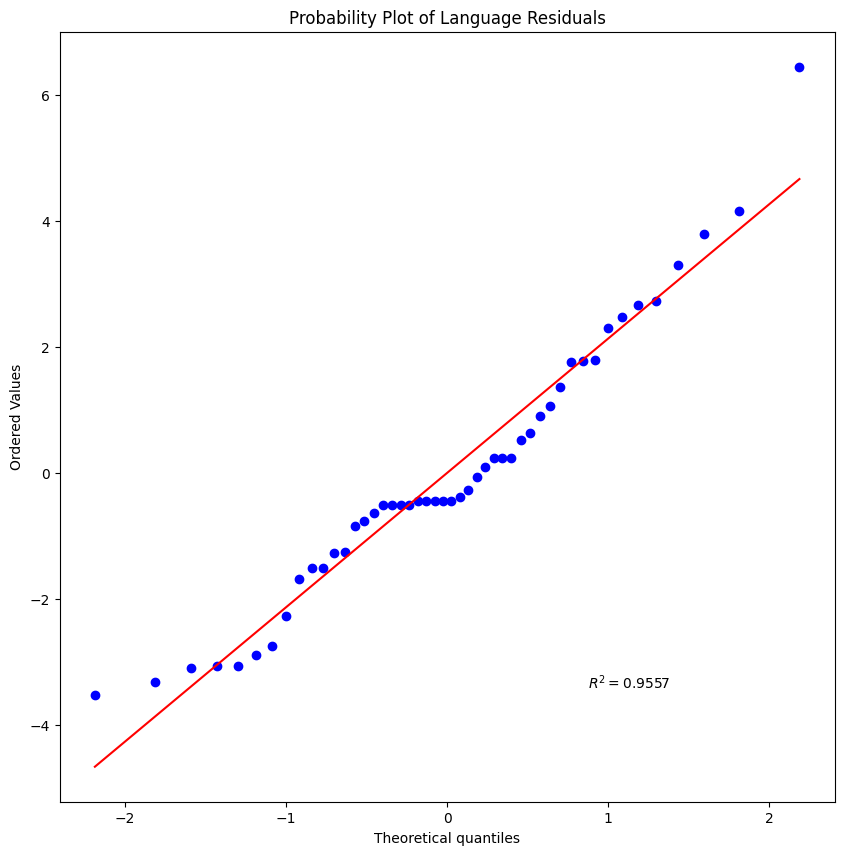

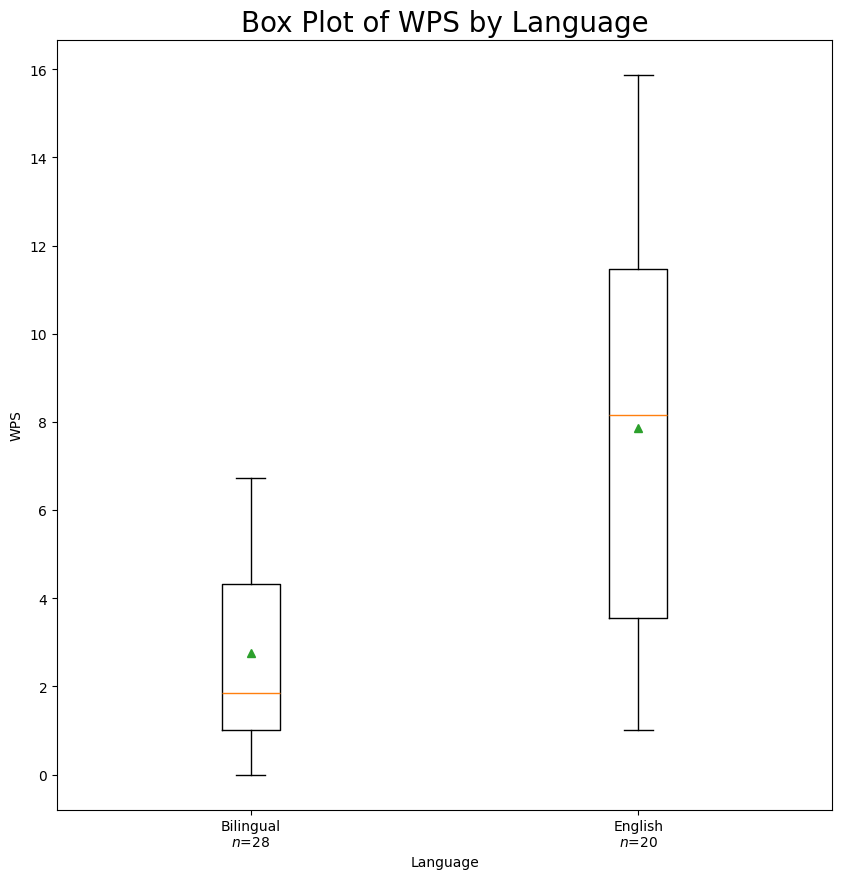

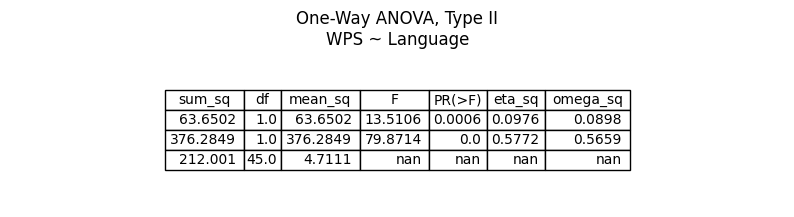

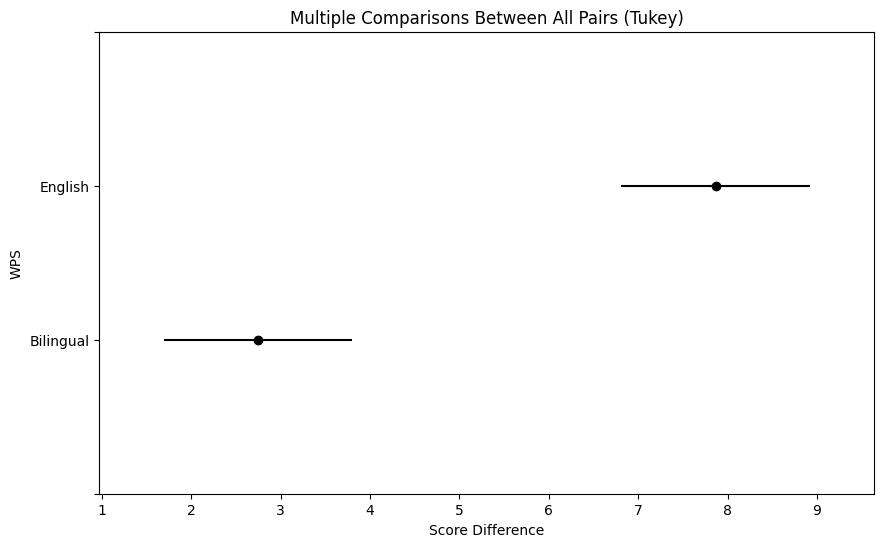

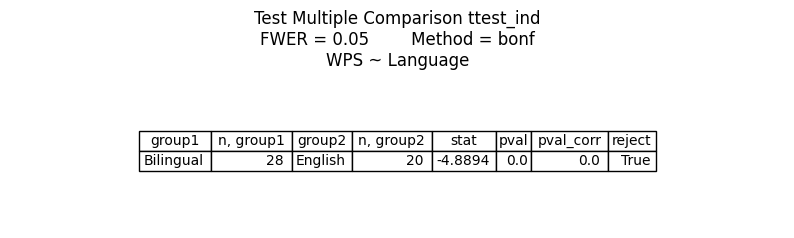

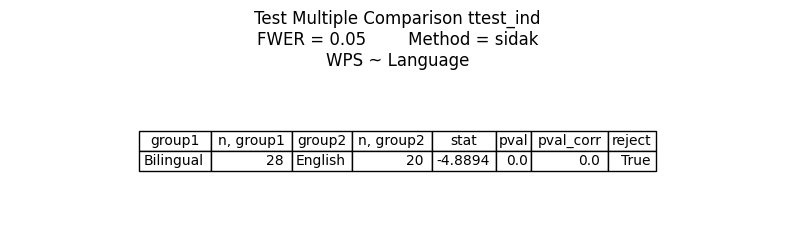

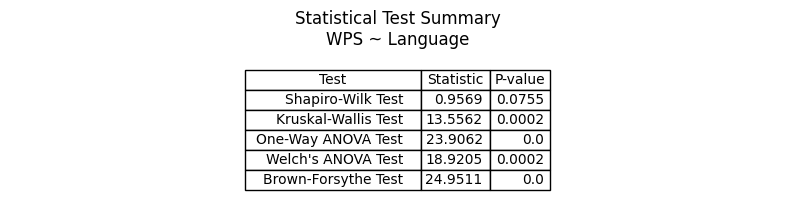

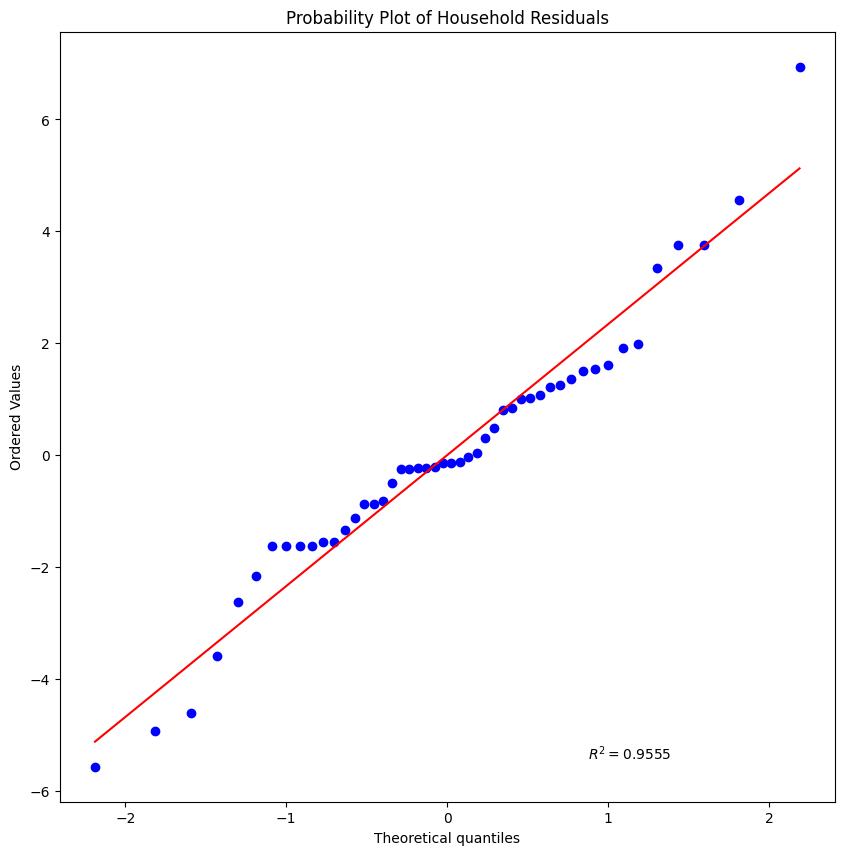

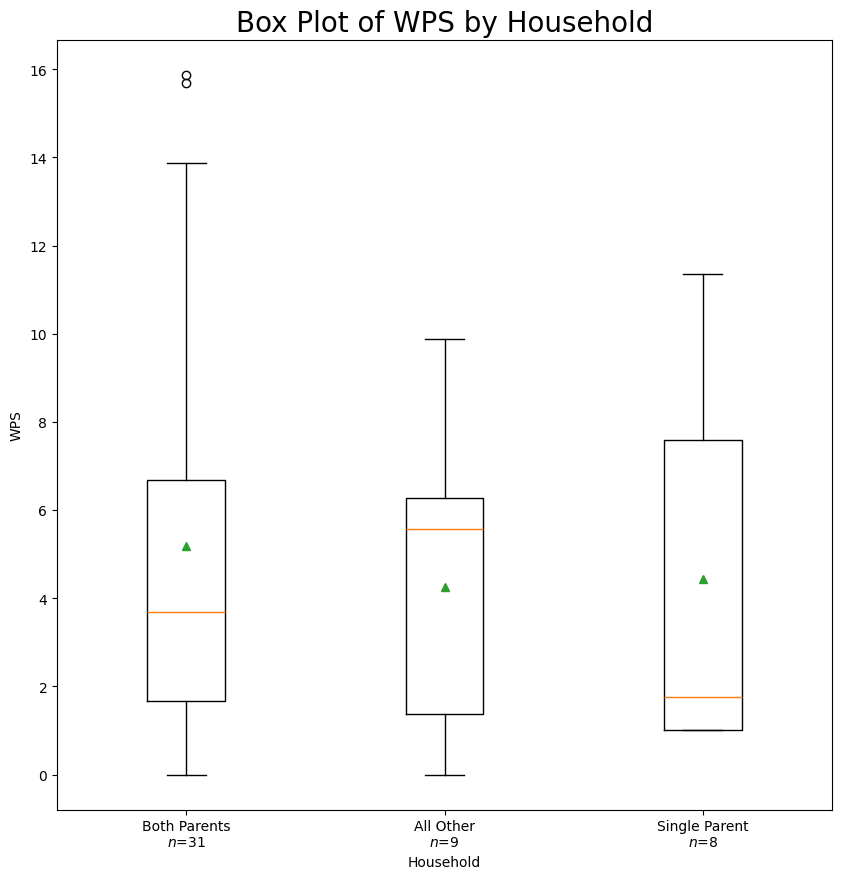

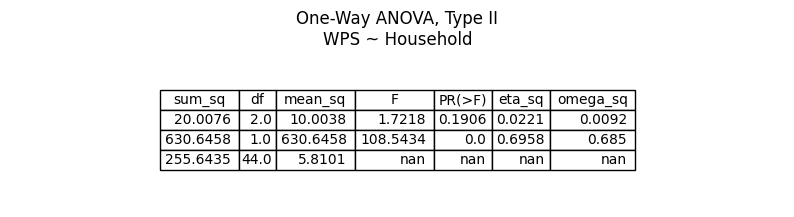

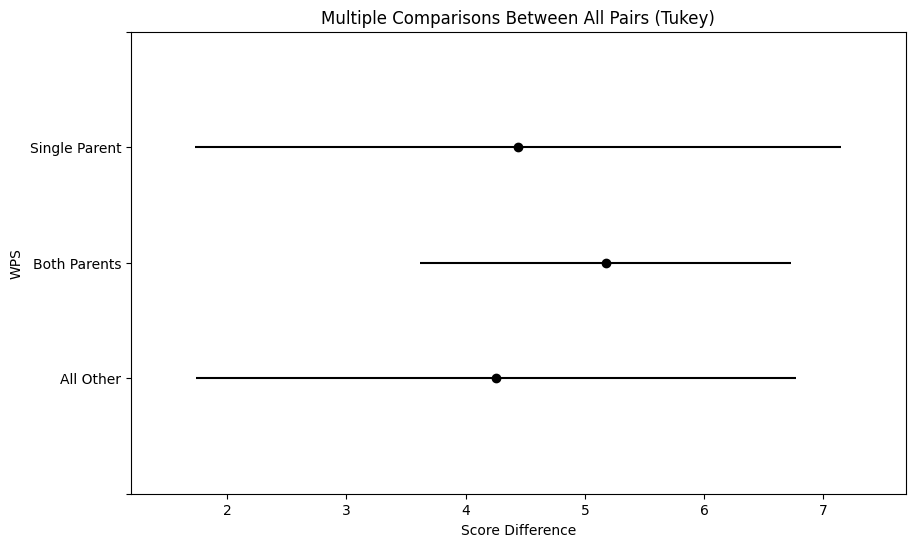

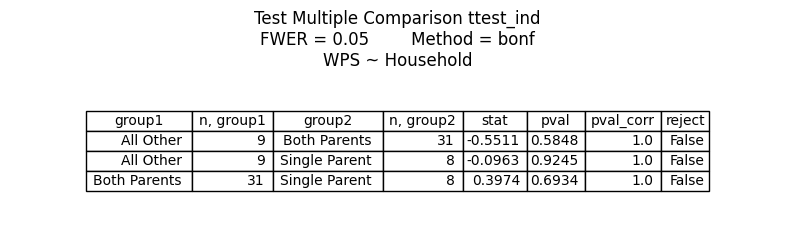

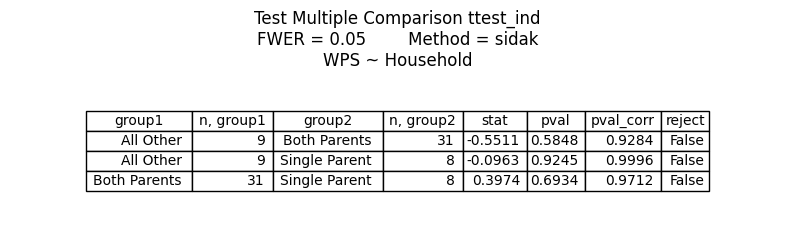

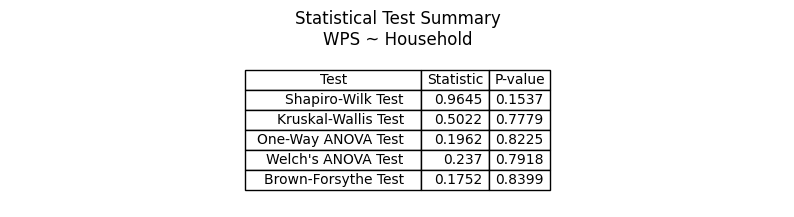

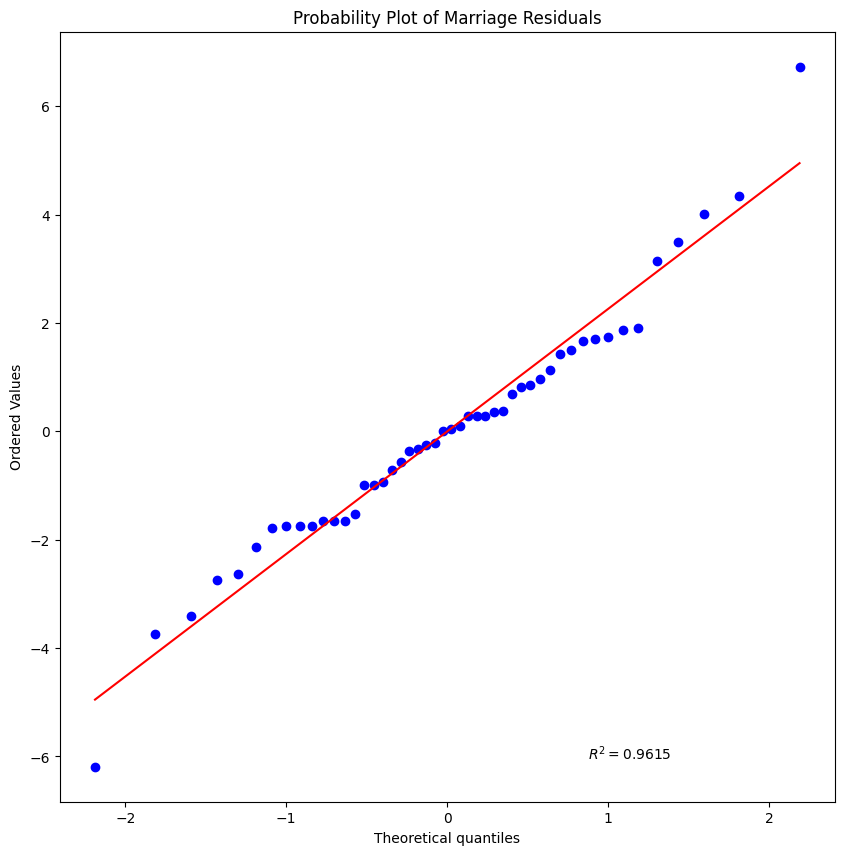

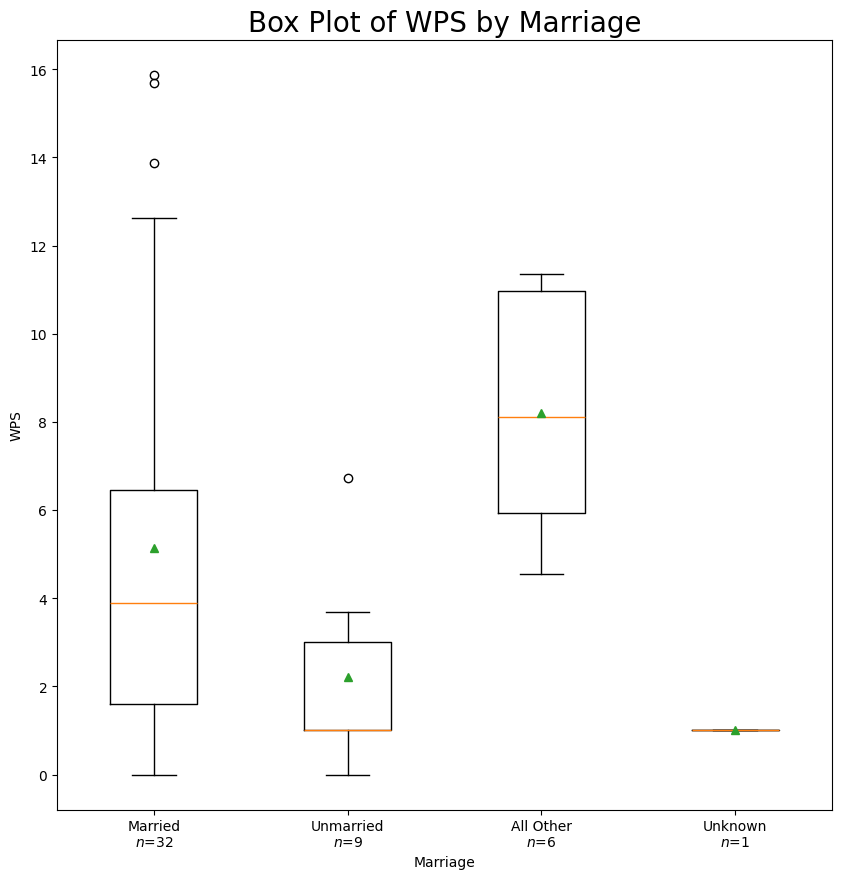

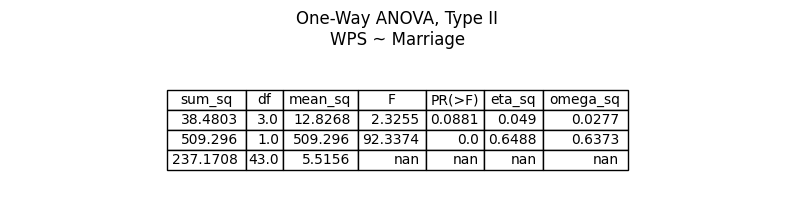

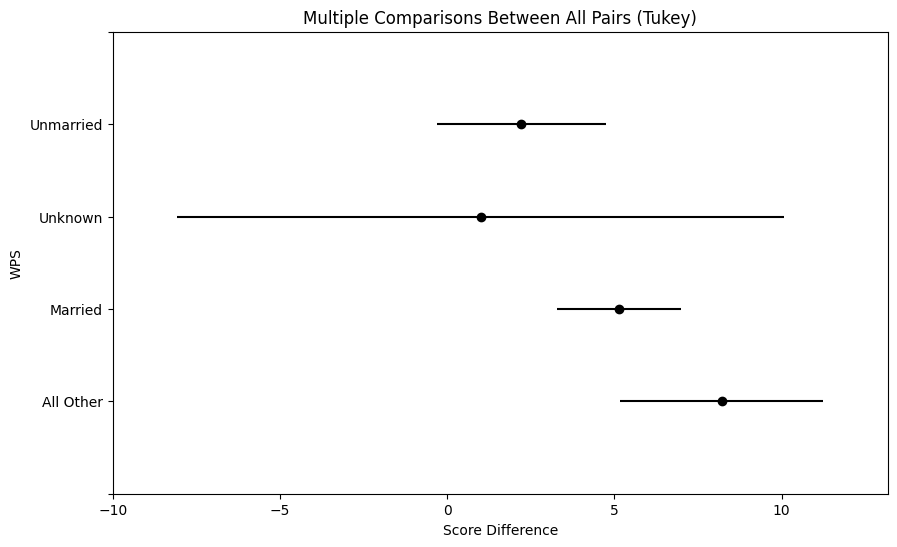

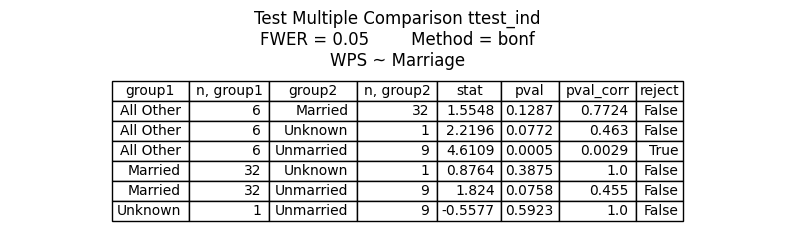

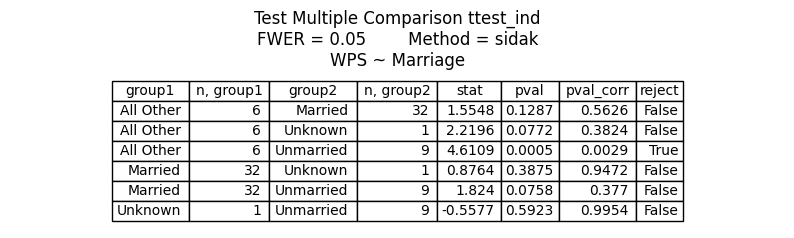

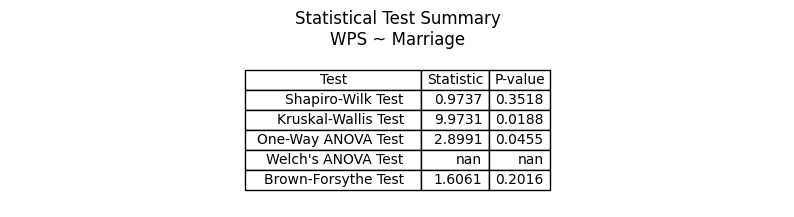

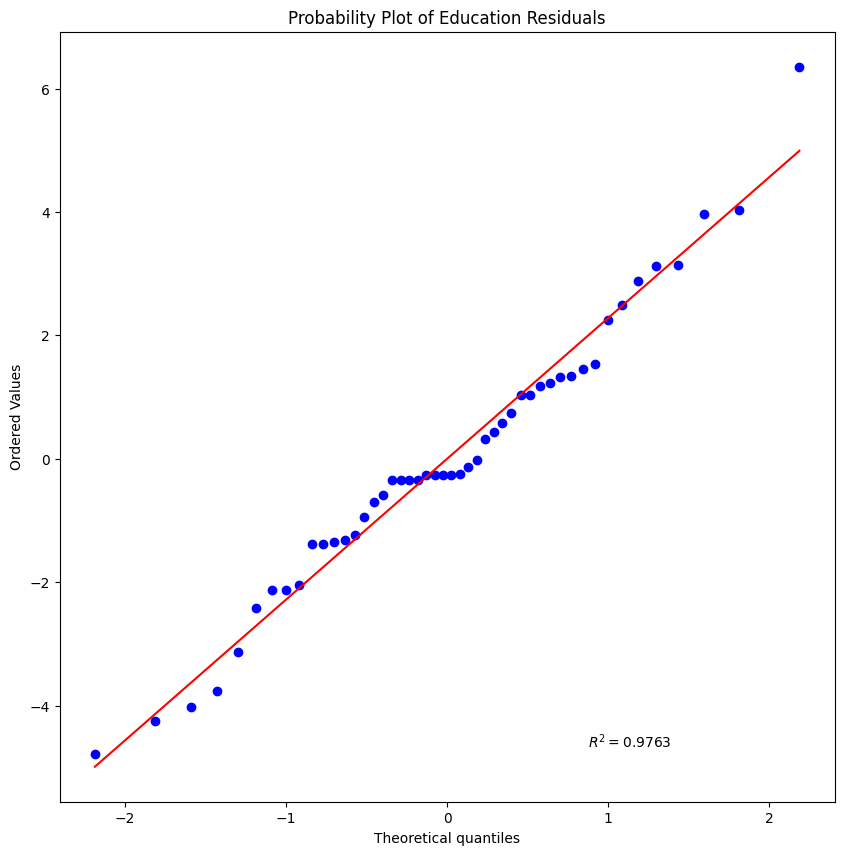

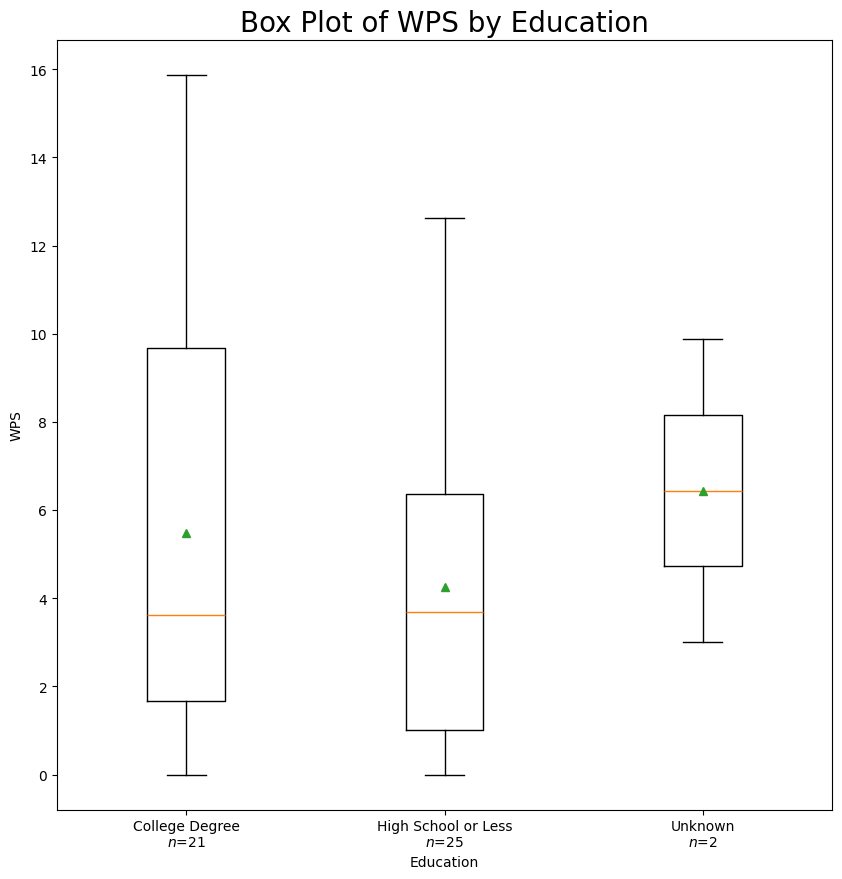

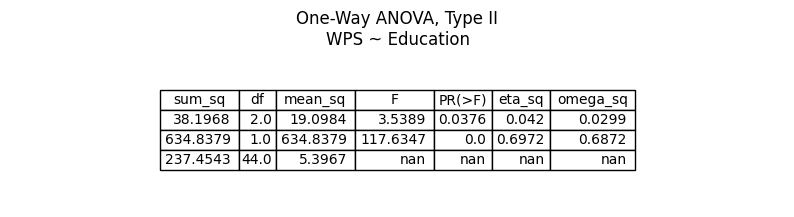

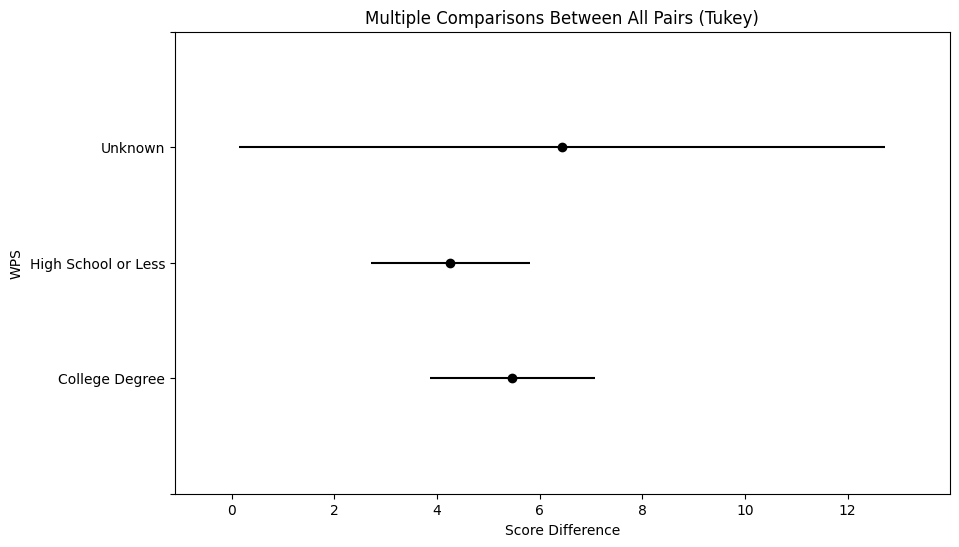

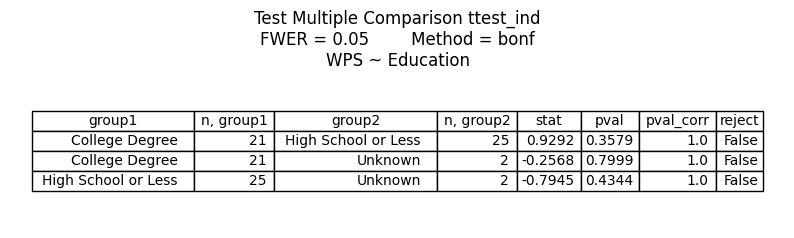

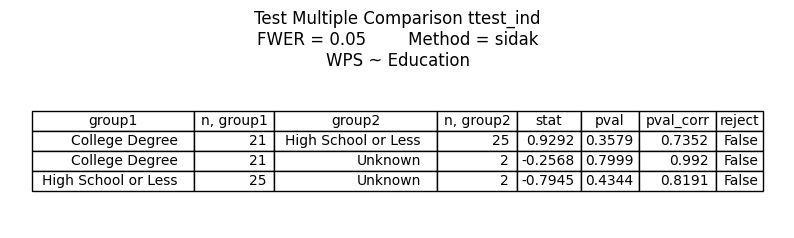

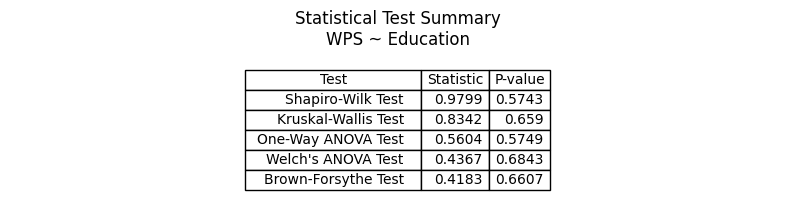

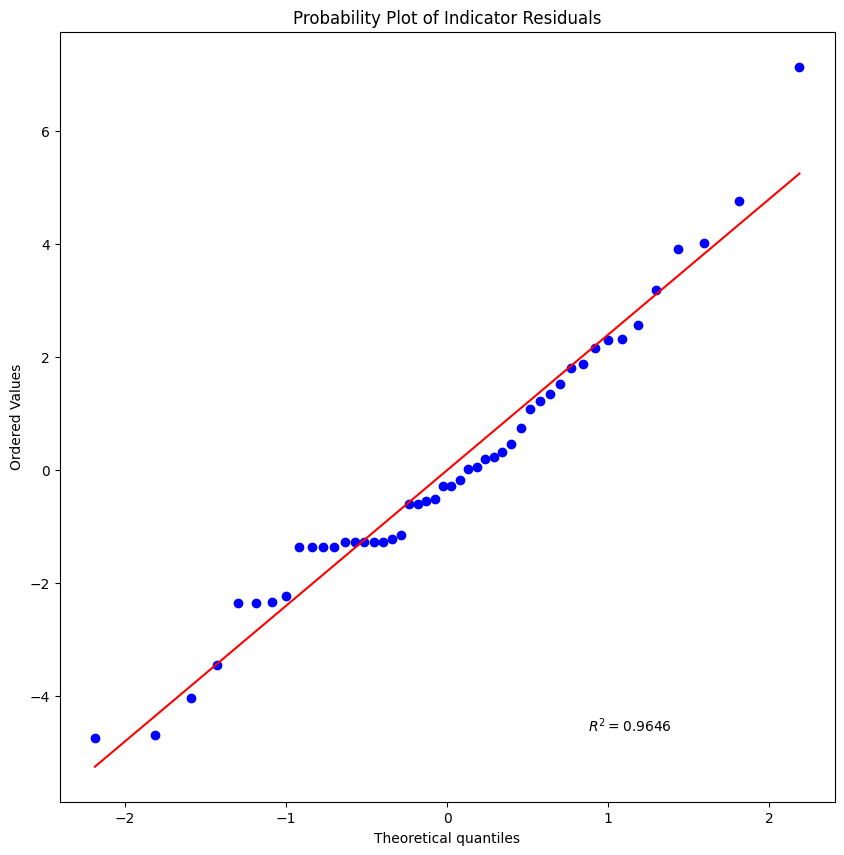

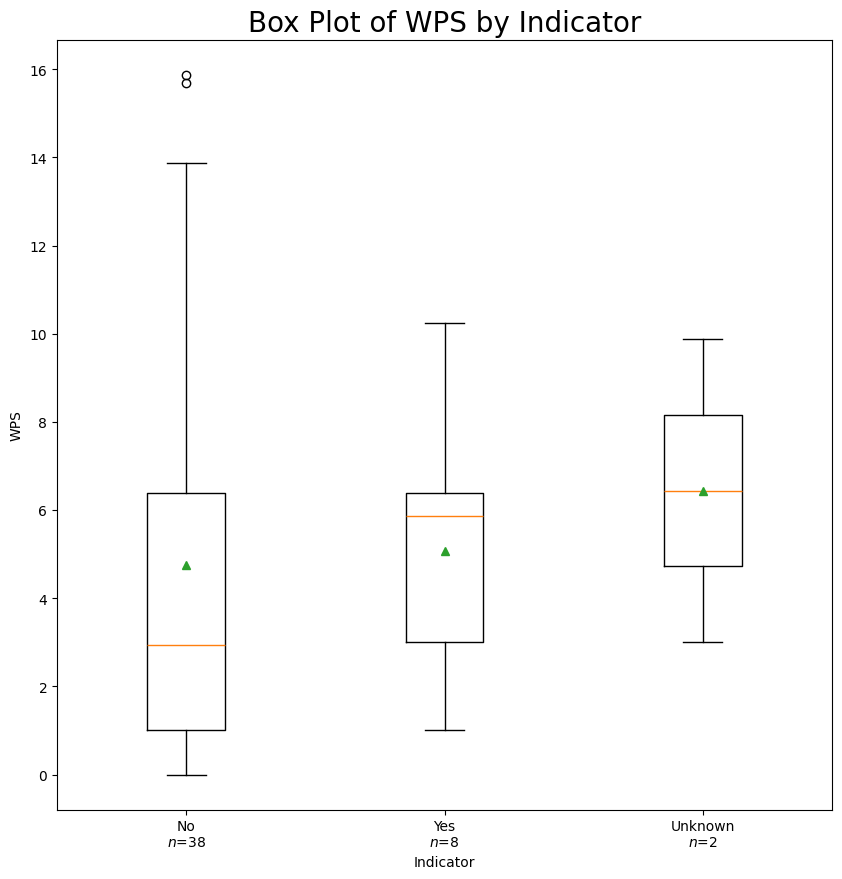

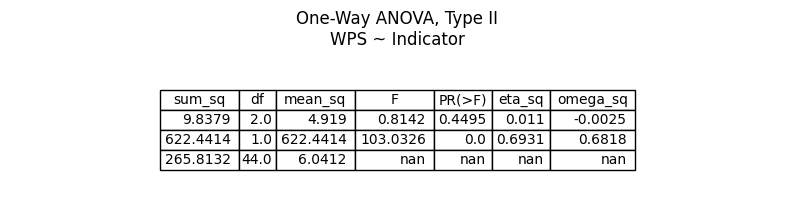

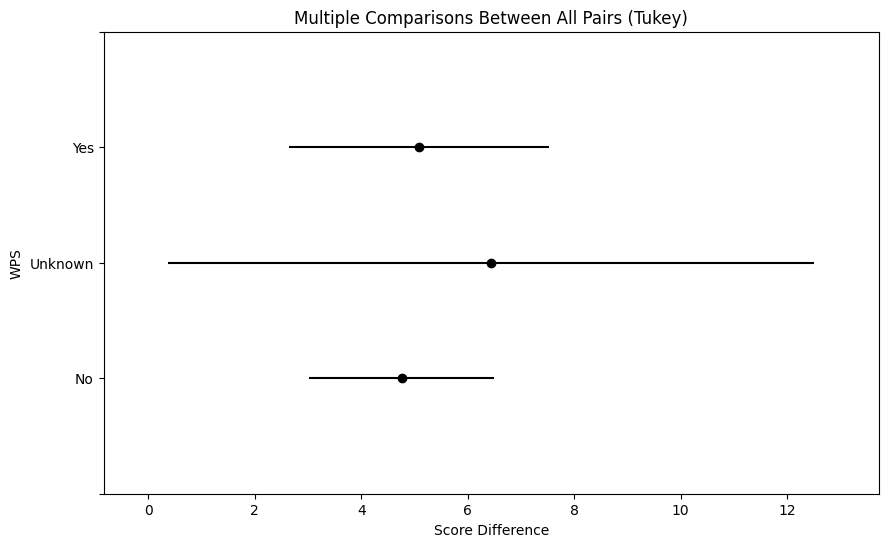

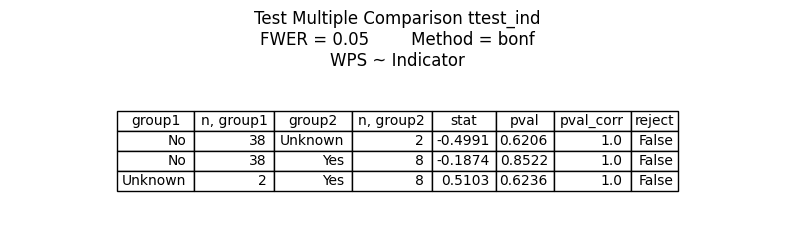

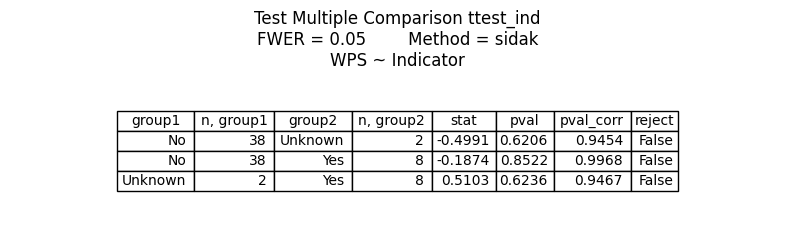

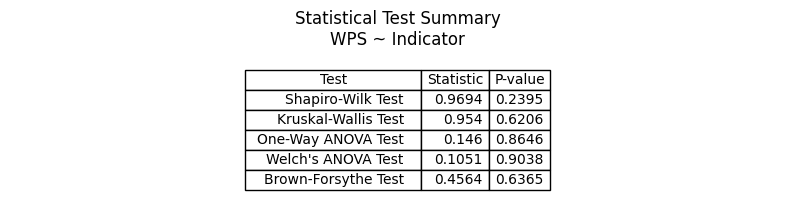

In [33]:
df_ess_dropna = df_ess.dropna(subset='WPS')
df_ess_dropna = df_ess_dropna.fillna('Unknown')
ivs = ['Language', 'Household', 'Marriage', 'Education', 'Indicator']
for v in ivs:
    GeneratePlots(df_ess_dropna, 'WPS', v, 'Age')

In [34]:
# Simple Linear Regression

model = ols('WPS ~ C(Language)*Age + C(Household)*Age + C(Marriage)*Age + C(Education)*Age + C(Indicator)*Age', df_ess)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WPS   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     18.15
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           8.03e-11
Time:                        13:51:05   Log-Likelihood:                -77.312
No. Observations:                  45   AIC:                             186.6
Df Residuals:                      29   BIC:                             215.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  11.3384      4.391      2.582      0.015       2.357      20.319
C(Language)[T.English]                     -0.6781      1.414     -0.480      0.635      -3.570       2.214
C(Household)[T.Both Parents]               -1.1264      1.514     -0.744      0.463      -4.224       1.971
C(Household)[T.Single Parent]              -2.3292      2.547     -0.914      0.368      -7.539       2.880
C(Marriage)[T.Married]                    -11.0969      4.134     -2.684      0.012     -19.552      -2.642
C(Marriage)[T.Unmarried]                  -10.5838      4.100     -2.581      0.015     -18.970      -2.198
C(Education)[T.High School or Less]         0.1884      1.054      0.179      0.859      -1.968       2.345
C(Indicator)[T.Yes]                         0.5077      1.722      0.295      0.770      -3.015       4.030
Age                                        -0.0593      0.047     -1.254      0.220      -0.156       0.037
C(Language)[T.English]:Age                  0.0299      0.027      1.114      0.275      -0.025       0.085
C(Household)[T.Both Parents]:Age            0.0345      0.023      1.477      0.150      -0.013       0.082
C(Household)[T.Single Parent]:Age           0.0528      0.041      1.290      0.207      -0.031       0.137
C(Marriage)[T.Married]:Age                  0.1152      0.041      2.813      0.009       0.031       0.199
C(Marriage)[T.Unmarried]:Age                0.0928      0.047      1.969      0.059      -0.004       0.189
C(Education)[T.High School or Less]:Age    -0.0177      0.013     -1.319      0.198      -0.045       0.010
C(Indicator)[T.Yes]:Age                    -0.0007      0.026     -0.028      0.978      -0.053       0.052
==============================================================================
Omnibus:                        7.007   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                6.078
Skew:                           0.875   Prob(JB):                       0.0479
Kurtosis:                       3.424   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

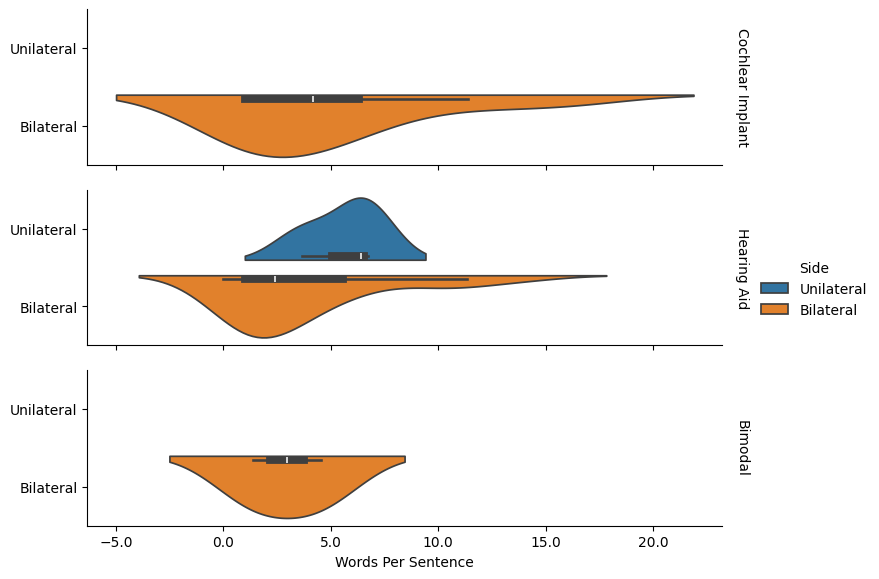

In [36]:
df_min = df_min[~df_min['Type'].isin(['Bone Conduction Device'])]

g = sns.catplot(
    data=df_min, x="WPS", y="Side", row="Type", hue="Side", kind="violin", split=True, orient="h", sharex=True, margin_titles=True, height=2, aspect=4
)
g.set(xlabel="Words Per Sentence", ylabel="")
g.set_titles(row_template="{row_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('{x:.1f}')

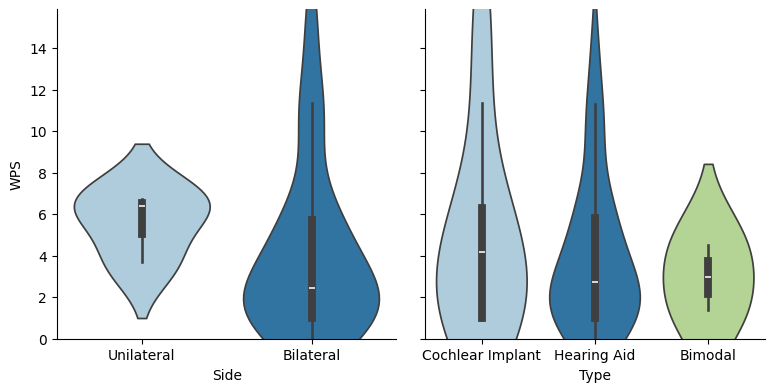

In [37]:


ha_model = ols('WPS ~ C(Type)*Age_Months + C(Side)*Age_Months', df_min)
ha_result = model.fit()

x_vars = ['Side', 'Type']
p = sns.PairGrid(data=df_min, y_vars=['WPS'], x_vars=x_vars, height=4, palette='Paired')
p.map(sns.violinplot)
p.set(ylim=(0, df_min['WPS'].max()))


[('F statistic', np.float64(1.656527804615747)),
 ('p-value', np.float64(0.23573016225621563))]

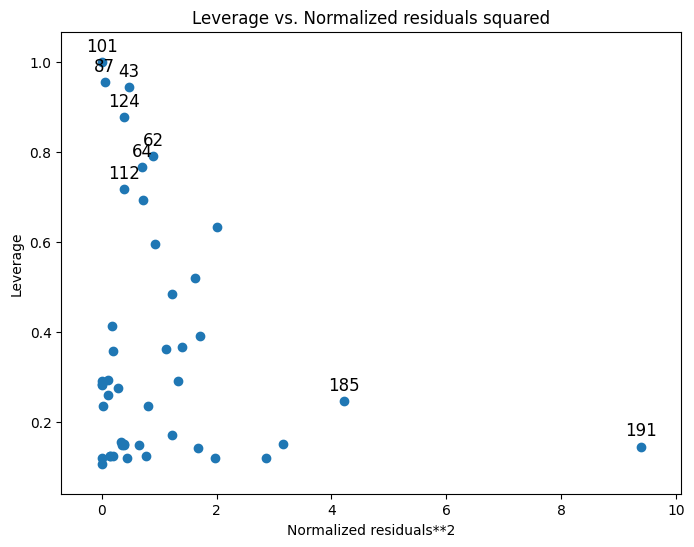

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

c2_name = ['Chi^2', 'Two-tail probability']
c2_test = sms.omni_normtest(res.resid)
lzip(c2_name, c2_test)

jb_name = ['Jarque-Bera test', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
jb_test = sms.jarque_bera(res.resid)
lzip(jb_name, jb_test)

dw_name = ['Durbin-Watson statistic']
dw_test = [sms.durbin_watson(res.resid)]
lzip(dw_name, dw_test)

bg_name = ['Breusch-Godfrey Lagrange multiplier test statistic', 'p-value', 'f-value', 'f p-value']
bg_test = sms.acorr_breusch_godfrey(res)
lzip(bg_name, bg_test)

cn_name = ["Condition Number"]
cn_test = [np.linalg.cond(res.model.exog)]
lzip(cn_name, cn_test)

fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(res, ax=ax)
test_class = OLSInfluence(res)
test_class.dfbetas[:5, :]

bp_name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
bp_test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(bp_name, bp_test)

gq_name = ["F statistic", "p-value"]
gq_test = sms.het_goldfeldquandt(res.resid, res.model.exog)
lzip(gq_name, gq_test)

In [41]:
oax = sms.OaxacaBlinder(res.model.endog, res.model.exog, 1)

print(oax.two_fold().summary())
print(oax.three_fold().summary())



Oaxaca-Blinder Two-fold Effects
Unexplained Effect: -4.00552
Explained Effect: 8.96119
Gap: 4.95567
None
Oaxaca-Blinder Three-fold Effects
Endowment Effect: 38.54774
Coefficient Effect: -12.33944
Interaction Effect: -21.25263
Gap: 4.95567
None
